In [1]:
# Load pickled data
import pickle
import random
import cv2
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import ndimage, misc


# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
######################### Data Preprocessing ########################
def sharpen(img):
    kernel_sharpening=np.array([[-1,-1,-1],
                                [-1, 9, -1],
                                [-1,-1,-1]])
    sharpened = cv2.filter2D(img, -1, kernel_sharpening)
    return sharpened

def rand_rot(image):
    image = ndimage.rotate(image, angle=random.randint(-5,5), reshape=False)
    return image

def rand_translate(image):
    x = random.randint(-5,5)
    y = random.randint(-5,5)
    num_rows, num_cols = image.shape[:2]
    translate_mat = np.float32([[1,0,x], [0,1,y]])
    #image = cv2.warpAffine(image, translate_mat, (num_cols, num_rows))
    image = cv2.warpAffine(image, translate_mat, (num_cols, num_rows))
    return image

def gauss_blur(image):
    x = random.randrange(1,3,2)
    image = cv2.GaussianBlur(image,(x, x), 0)
    return image

def increase_brightness(image, value=30):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return image

def left_warp(image):
    rows = image.shape[0]
    cols = image.shape[1]
    img_size = (image.shape[1], image.shape[0])
    
    x1 = rows/4
    x2 = 3*rows/4
    y1 = cols/4
    y2 = 3*cols/4
      
    src_points = np.float32(
    [[x1,  y2],
     [x1,  y1],
     [x2,  y1],
     [x2, y2]])

    #left tilt
    dst_points = np.float32(
    [[x1+2,  y2-3],
     [x1+2,  y1+3],
     [x2+3,  y1],
     [x2+3, y2]])
      
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
    
def right_warp(image):
    rows = image.shape[0]
    cols = image.shape[1]
    img_size = (image.shape[1], image.shape[0])
    
    x1 = rows/4
    x2 = 3*rows/4
    y1 = cols/4
    y2 = 3*cols/4
      
    src_points = np.float32(
    [[x1,  y2],
     [x1,  y1],
     [x2,  y1],
     [x2, y2]])
    
    #right tilt
    dst_points = np.float32(
    [[x1+2,  y2-1],
     [x1+2,  y1+1],
     [x2-3,  y1+3],
     [x2-3, y2-3]])
    
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

#Create dictionary of image augmentation functions
Augmentation = {
    'Random Rotation' : rand_rot,
    'Random Translate' : rand_translate,
    'Gaussian Blur'   : gauss_blur,
    'Brightness'     : increase_brightness,
    'Left Warp' : left_warp,
    'Right Warp' : right_warp
}
################### Increase data set size ############################

bins = np.arange(0,44,1).tolist()

histogram = np.histogram(y_train, bins=bins)

add_images = []
add_y = []
"""  
min_val = 1500
for i in range(len(histogram[1])-1):
    curr_val = histogram[0][i]
    while curr_val < min_val:
        for j in range(n_train):
            if y_train[j] == i:
                copy = X_train[j]
                add_images.append(copy)
                add_y.append(y_train[j])
                curr_val +=1   
                
add_images = np.array(add_images)
add_y = np.array(add_y)
"""
add_images = []
add_y = []

min_val = 2000
for i in range(len(histogram[1])-1):
    curr_val = histogram[0][i]
    while curr_val < min_val:
        for j in range(n_train):
            if curr_val == min_val:
                break
            else:
                if y_train[j] == i:
                    copy = X_train[j]
                    add_images.append(copy)
                    add_y.append(y_train[j])
                    curr_val +=1    
                  
print('Number of images to be added to overall data set: ', len(add_images))
                
X_train_new = np.concatenate((X_train, add_images), axis=0)
y_train_new = np.concatenate((y_train, add_y), axis=0)

X_train = X_train_new
y_train = y_train_new

print('New number of train images = ', X_train.shape)

################### Randomly augment images in total data set ############################
"""
#Iterate through each y_label of the data set 
histogram = np.histogram(y_train, bins=bins)
print('histogram check = ', histogram[0][1])
#Iterate through each y_label of the data set 
for i in range(len(histogram[1])-1):
    # Iterate through entire data set in search of the y_label(i)
    for j in range(len(y_train)):
        # if y_labe is equal to i, then random augment that image
        if y_train[j] == i:
            sharp_img = sharpen(X_train[j])
            key = random.choice(list(Augmentation))
            new_image = Augmentation[key](sharp_img)
            X_train[j]= new_image
"""
#Iterate through each y_label of the data set 
histogram = np.histogram(y_train, bins=bins)
print('histogram check = ', histogram[0][1])
#Iterate through each y_label of the data set
for i in range(len(histogram[1])-1):
    # Iterate through entire data set in search of the y_label(i)
    for j in range(len(y_train)):
        # if y_labe is equal to i, then random augment that image
        if y_train[j] == i:
            ## Sharpened ang brighten each image before random augmentation
            sharp_img = sharpen(X_train[j])
            bright_img = increase_brightness(sharp_img, value=30)
            key = random.choice(list(Augmentation))
            new_image = Augmentation[key](sharp_img)
            X_train[j]= new_image

            
############## Sharpen/Brighten Validation  and Test Images ########################
for i in range(len(X_valid)):
    sharp_valid = sharpen(X_valid[i])
    bright_valid = increase_brightness(sharp_valid)
    X_valid[i] = bright_valid
    

for j in range(len(X_test)):
    sharp_test = sharpen(X_test[j])
    bright_test = increase_brightness(sharp_test)
    X_test[j] = bright_test
    
print('finished sharpening and brightening')                
####################Convert to grayscale#############################

X_train_gray = np.sum(X_train/3, axis=3, keepdims=True)
X_valid_gray = np.sum(X_valid/3, axis=3, keepdims=True)
X_test_gray = np.sum(X_test/3, axis=3, keepdims=True)

                
###################Standardize data#####################################           

"""
d1,d2,d3,d4 = X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]
v1,v2,v3,v4 = X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], X_valid.shape[3]
t1,t2,t3,t4 = X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3]
X_train = X_train.reshape(d1,d2*d3*d4)
X_valid = X_valid.reshape(v1,v2*v3*v4)
X_test = X_test.reshape(t1,t2*t3*t4)
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_rescale = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
np.set_printoptions(precision=3)
X_train = X_rescale.reshape(d1,d2,d3,d4)
X_valid = X_valid.reshape(v1,v2,v3,v4)
X_test = X_test.reshape(t1,t2,t3,t4)
"""      
X_train_normalized = (X_train_gray - 128)/128 
X_valid_normalized = (X_valid_gray - 128)/128
X_test_normalized = (X_test_gray - 128)/128


####################Shuffle Data#############################
X_train_normalized, y_train = shuffle(X_train_normalized, y_train)

###################### CNN Model ###################

def conv2d(x,W,b, strides=1):
    x = tf.nn.conv2d(x,W,strides=[1,strides,strides,1], padding='VALID')
    x = tf.nn.bias_add(x,b)
    #x = tf.nn.relu(x)
    return x

def maxpool2d(x,k=2):
    mp = tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='VALID')
    return mp

def LeNet_OG(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights = {
        'wc1': tf.Variable(tf.truncated_normal(shape = [5,5,1,6], mean=mu, stddev=sigma)),
        'wc2': tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean=mu, stddev=sigma)),
        'wf1': tf.Variable(tf.truncated_normal(shape = [400, 120], mean = mu, stddev=sigma)),
        'wf2': tf.Variable(tf.truncated_normal(shape = [120, 84], mean = mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([84,43], mean=mu, stddev=sigma))
    }
    
    biases = {
        'bc1': tf.Variable(tf.zeros(6)),
        'bc2': tf.Variable(tf.zeros(16)),
        'bf1': tf.Variable(tf.zeros(120)),
        'bf2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(43))
    }
    
    #output_height = ceil(in_height-filter_height +1/strides)
    
    ############## Layer 1 Convolutional ######################
    #Layer1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    #print(x.shape)
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    #Layer1: Activation.
    conv1 = tf.nn.relu(conv1)
    #Layer1: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1, k=2)
    #print(conv1.shape)
    ############## Layer 2 Convolutional ######################
    #Layer2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    #Layer2: Activation.
    conv2 = tf.nn.relu(conv2)
    #Layer2: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2, k=2)
    #print(conv2.shape)
    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    fc0 = tf.nn.dropout(fc0, keep_prob)
    ############## Layer 3 Fully Connected ######################
    #Layer3: Fully Connected. Input = 400. Output = 120.
    ful_con1 = tf.add(tf.matmul(fc0, weights['wf1']), biases['bf1'])
    #Layer3: Activation.
    ful_con1 = tf.nn.relu(ful_con1)
    #Layer 3: Dropout
    ful_con1 = tf.nn.dropout(ful_con1, keep_prob)
    ############## Layer 4 Fully Connected ######################
    #Layer4: Fully Connected. Input = 120. Output = 84.
    ful_con2 = tf.add(tf.matmul(ful_con1, weights['wf2']), biases['bf2'])
    #Layer4: Activation.
    ful_con2 = tf.nn.relu(ful_con2)
    #Layer5: Dropout
    ful_con2 = tf.nn.dropout(ful_con2, keep_prob)
    ############## Layer 5 Fully Connected ######################
    #Layer5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(ful_con2, weights['out']), biases['out'])
    
    return logits

######################## New LeNet Configuration #############################

def LeNet_new(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights = {
        'wc1': tf.Variable(tf.truncated_normal(shape = [5,5,1,6], mean=mu, stddev=sigma)),
        'wc2': tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean=mu, stddev=sigma)),
        'wc3': tf.Variable(tf.truncated_normal(shape = [5,5,16,400], mean = mu, stddev=sigma)),
        'wf2': tf.Variable(tf.truncated_normal(shape = [800, 84], mean = mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([84,43], mean=mu, stddev=sigma))
        #'out': tf.Variable(tf.truncated_normal([800,43], mean=mu, stddev=sigma))
    }
    
    biases = {
        'bc1': tf.Variable(tf.zeros(6)),
        'bc2': tf.Variable(tf.zeros(16)),
        'bc3': tf.Variable(tf.zeros(400)),
        'bf2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(43))
    }
    
    #output_height = ceil(in_height-filter_height +1/strides)
    
    ############## Layer 1 Convolutional ######################
    #Layer1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    #print(x.shape)
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    #Layer1: Activation.
    conv1 = tf.nn.relu(conv1)
    #Layer1: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1, k=2)
    #print(conv1.shape)
    ############## Layer 2 Convolutional ######################
    #Layer2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    #Layer2: Activation.
    conv2 = tf.nn.relu(conv2)
    #Layer2: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2, k=2)
    #print(conv2.shape)
    # Flatten. Input = 5x5x16. Output = 400.
    layer2_flat = flatten(conv2)
    ############## Layer 3 Convolutional ######################
    #Layer3: Fully Connected. Input = 5x5x16. Output = 1x1x400.
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    #Layer3: Activation.
    conv3 = tf.nn.relu(conv3)
    # Flatten. Input = 1x1x400. Output =400
    layer3_flat = flatten(conv3)
    
    conv_out = tf.concat([layer3_flat, layer2_flat], 1)
    #print('conv out shape = ', conv_out.shape)
    
    ############## Output layer ##############################
    #logits = tf.add(tf.matmul(conv_out, weights['out']), biases['out'])
    
    
    ############## Layer 4 Fully Connected ######################
    #Layer4: Fully Connected. Input = 800. Output = 84.
    ful_con2 = tf.add(tf.matmul(conv_out, weights['wf2']), biases['bf2'])
    #Layer4: Activation.
    ful_con2 = tf.nn.relu(ful_con2)
    #Layer5: Dropout
    ful_con2 = tf.nn.dropout(ful_con2, keep_prob)
    ############## Layer 5 Fully Connected ######################
    #Layer5: Fully Connected. Input = 84. Output = 10.
    logits = tf.add(tf.matmul(ful_con2, weights['out']), biases['out'])
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='x_dat')
y = tf.placeholder(tf.int32, (None), name='y_dat')
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Number of images to be added to overall data set:  51211
New number of train images =  (86010, 32, 32, 3)
histogram check =  2000
finished sharpening and brightening


In [2]:
######################## Hyperparameters #####################################
rate = 0.001
EPOCHS = 15
BATCH_SIZE = 64
#keep_prob = 0.5

print('learning rate = ', rate)
print('epochs = ', EPOCHS)
print('batch size = ', BATCH_SIZE)
#print('dropout rate = ', keep_prob)

######################## Training Pipeline ###################################
logits = LeNet_OG(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

######################## Model Evaluation ###################################
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('finished')

learning rate =  0.001
epochs =  15
batch size =  64
finished


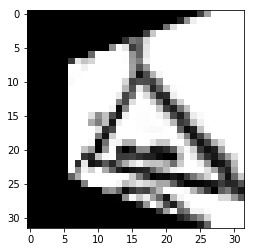

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
img = X_train_normalized[7].squeeze()
plt.imshow(img, cmap='gray')

100


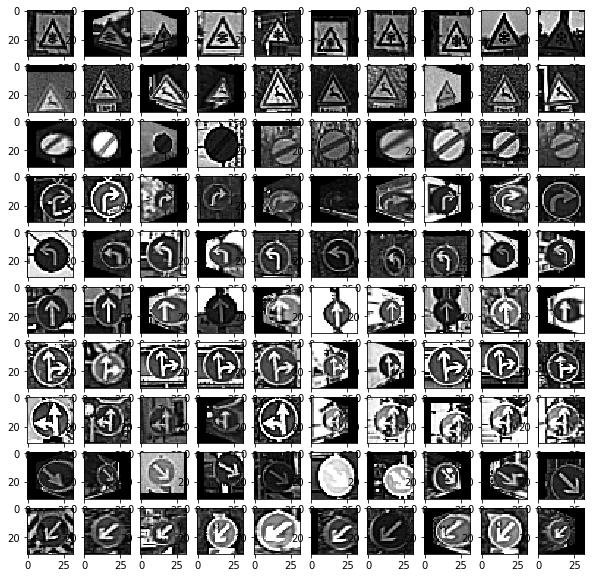

In [4]:
img_list =  []

for i in range(30,40):
    count = 0
    for j in range(len(y_train)):
        if y_train[j] == i:
            img_list.append(X_train_normalized[j])
            count += 1
        if count >=10:
            break
print(len(img_list))

fig = plt.figure(figsize=(10,10))
cols = 10
rows = 10
for i in range(1,rows*cols+1):
    ax = fig.add_subplot(rows,cols,i)
    img = img_list[i-1].squeeze()
    plt.imshow(img, cmap='gray')

plt.show()

### Train the Model

In [5]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalized)
    #initialize empty list to store validation accuracy
    acc_list = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.85})
            
        validation_accuracy = evaluate(X_valid_normalized, y_valid)
        acc_list.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.854

EPOCH 2 ...
Validation Accuracy = 0.905

EPOCH 3 ...
Validation Accuracy = 0.933

EPOCH 4 ...
Validation Accuracy = 0.940

EPOCH 5 ...
Validation Accuracy = 0.956

EPOCH 6 ...
Validation Accuracy = 0.944

EPOCH 7 ...
Validation Accuracy = 0.956

EPOCH 8 ...
Validation Accuracy = 0.960

EPOCH 9 ...
Validation Accuracy = 0.963

EPOCH 10 ...
Validation Accuracy = 0.956

EPOCH 11 ...
Validation Accuracy = 0.959

EPOCH 12 ...
Validation Accuracy = 0.958

EPOCH 13 ...
Validation Accuracy = 0.964

EPOCH 14 ...
Validation Accuracy = 0.957

EPOCH 15 ...
Validation Accuracy = 0.959

Model saved


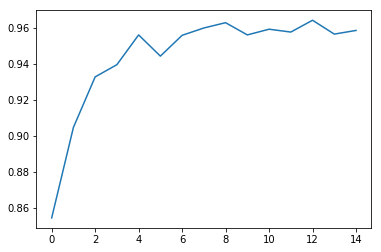

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
x_list = np.arange(len(acc_list))
plt.plot(x_list,acc_list)

In [7]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.942


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

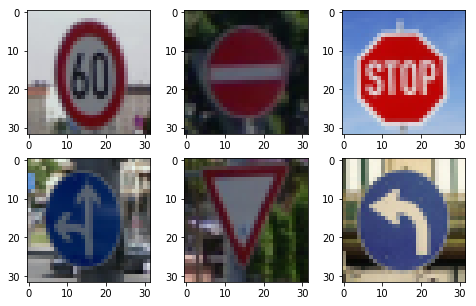

In [8]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

my_images = []
labels =[3 , 17 , 14 , 37 , 13 , 34]


for img in sorted(glob.glob('My_signs/*.PNG')):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA)
    my_images.append(img)
    
    
fig = plt.figure(figsize=(8,5))
cols = 3
rows = 2
for i in range(1,rows*cols+1):
    ax = fig.add_subplot(rows,cols,i)
    img = my_images[i-1]
    plt.imshow(img)

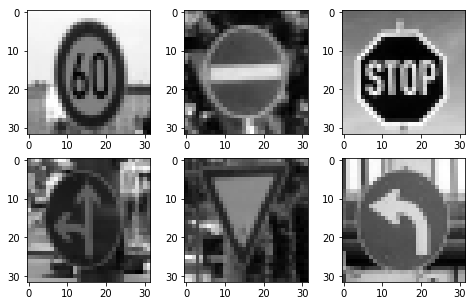

In [9]:
#Grayscale and Normalize my signs
my_images = np.array(my_images)
my_images_gray = np.sum(my_images/3, axis = 3, keepdims=True)
my_images_norm = (my_images_gray - 128)/128

fig2 = plt.figure(figsize=(8,5))

for i in range(1,rows*cols+1):
    ax = fig2.add_subplot(rows,cols,i)
    imgs = my_images_norm[i-1].squeeze()
    plt.imshow(imgs, cmap='gray')

### Predict the Sign Type for Each Image

In [10]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    myTest_accuracy = evaluate(my_images_norm, labels)
    print("My Test Accuracy = {:.3f}".format(myTest_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
My Test Accuracy = 1.000


### Analyze Performance

In [11]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./lenet
(1, 32, 32, 3)


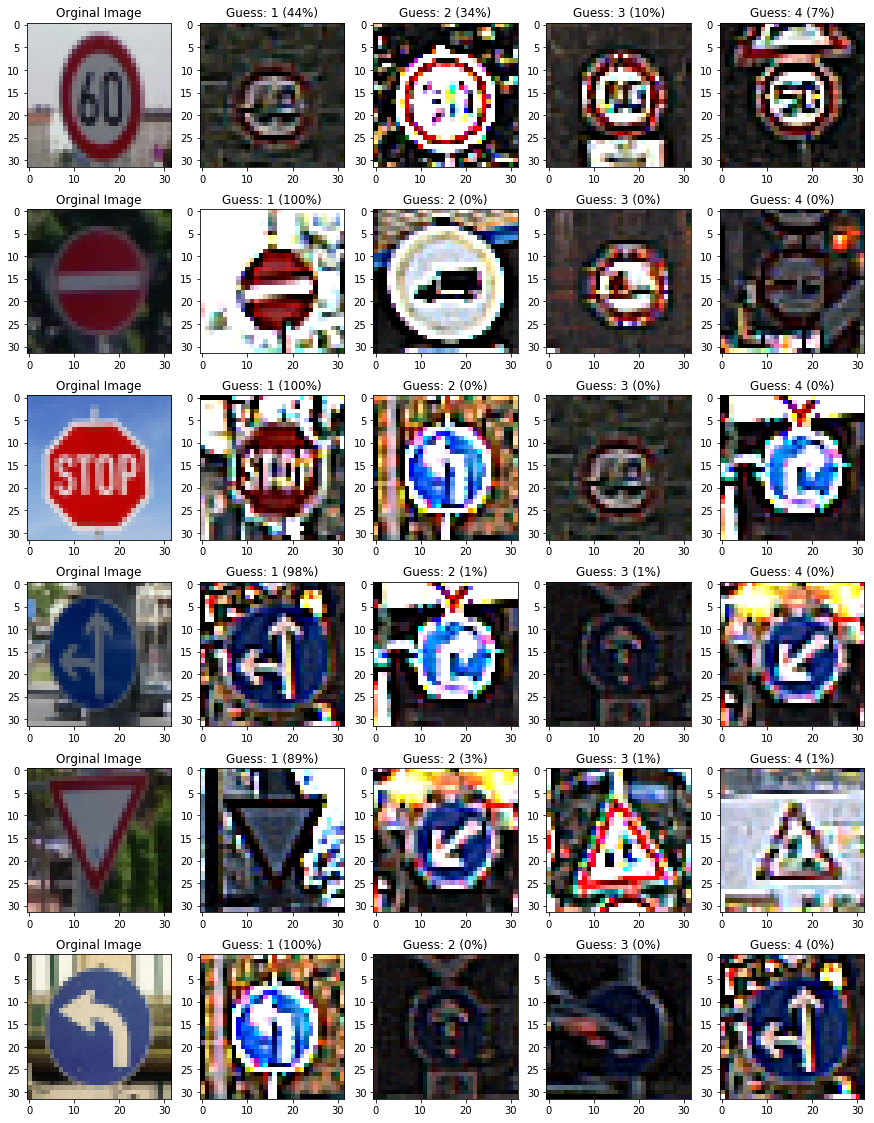

In [12]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
softmax_logits = tf.nn.softmax(logits)
k_size = 4
top_k = tf.nn.top_k(softmax_logits, k=k_size)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images_norm, keep_prob: 1.0})
    top_k_out = sess.run(top_k, feed_dict={x:my_images_norm, keep_prob: 1.0})
    
    TopKV, indicies = top_k_out

images =[]
guess = []
img_count = 0
for i in range(len(TopKV)): # len = 6
    for j in range(-1,k_size): # len k_size = 4
        if j == -1:
            images.append(my_images[img_count])
            guess.append(0)
            img_count +=1
        else:
            index = np.argwhere(y_valid == indicies[i][j])[0]
            images.append(X_valid[index])
            guess.append(TopKV[i][j])
            
rows = len(TopKV)
cols = k_size+1
fig3 = plt.figure(figsize=(15,20))

print(images[1].shape)

for i in range(1,rows*cols+1):
    ax = fig3.add_subplot(rows,cols,i)
    if guess[i-1] == 0:
        plot_img = images[i-1]
        ax.set_title('Orginal Image')
        guess_number = 0
    else:
        guess_number +=1
        plot_img = images[i-1]
        ax.set_title('Guess: {} ({:.0f}%)'.format(guess_number, 100*guess[i-1]))
    imgs = plot_img.squeeze()
    plt.imshow(imgs,cmap='gray')
  

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [13]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")